# Wall and Room Detection Model

This notebook demonstrates the process of detecting walls and rooms in floorplan images.

In [10]:
# Import basic libraries
import numpy as np  # linear algebra
import pandas as pd  # data processing, CSV file I/O (e.g. pd.read_csv)
import os

In [11]:
# List input data files
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

In [12]:
# Disable W&B prompt if not using W&B
if os.environ.get("WANDB", "OFF").upper() == "OFF":
    os.environ["WANDB_MODE"] = "disabled"
else:
    # Use this to avoid CLI prompt and auto login with your key
    import wandb
    wandb.login(key=os.environ.get("WANDB_API_KEY", "your_wandb_key_here"))

In [13]:
# Import CubiCasa5k data
import kagglehub
qmarva_cubicasa5k_path = kagglehub.dataset_download('qmarva/cubicasa5k')

print('Data source import complete.')

Data source import complete.


In [14]:
# Clone CubiCasa repository
!git clone https://github.com/CubiCasa/CubiCasa5k

Cloning into 'CubiCasa5k'...


In [15]:
# Change to CubiCasa5k directory
%cd CubiCasa5k

c:\Users\USER\Desktop\vit_project\detection\CubiCasa5k\CubiCasa5k


In [16]:
# Install required packages
!pip install lmdb
!pip install svgpathtools
!pip install pycocotools

Defaulting to user installation because normal site-packages is not writeable



[notice] A new release of pip is available: 25.0.1 -> 25.1.1
[notice] To update, run: python.exe -m pip install --upgrade pip


Defaulting to user installation because normal site-packages is not writeable



[notice] A new release of pip is available: 25.0.1 -> 25.1.1
[notice] To update, run: python.exe -m pip install --upgrade pip


Defaulting to user installation because normal site-packages is not writeable
  Using cached pycocotools-2.0.8.tar.gz (24 kB)
  Installing build dependencies: started
  Installing build dependencies: finished with status 'done'
  Getting requirements to build wheel: started
  Getting requirements to build wheel: finished with status 'done'
  Preparing metadata (pyproject.toml): started
  Preparing metadata (pyproject.toml): finished with status 'done'
Failed to build pycocotools


  error: subprocess-exited-with-error
  
  × Building wheel for pycocotools (pyproject.toml) did not run successfully.
  │ exit code: 1
  ╰─> [13 lines of output]
      running bdist_wheel
      running build
      running build_py
      creating build\lib.win-amd64-cpython-313\pycocotools
      copying pycocotools\coco.py -> build\lib.win-amd64-cpython-313\pycocotools
      copying pycocotools\cocoeval.py -> build\lib.win-amd64-cpython-313\pycocotools
      copying pycocotools\mask.py -> build\lib.win-amd64-cpython-313\pycocotools
      copying pycocotools\__init__.py -> build\lib.win-amd64-cpython-313\pycocotools
      running build_ext
      Compiling pycocotools/_mask.pyx because it changed.
      [1/1] Cythonizing pycocotools/_mask.pyx
      building 'pycocotools._mask' extension
      error: Microsoft Visual C++ 14.0 or greater is required. Get it with "Microsoft C++ Build Tools": https://visualstudio.microsoft.com/visual-cpp-build-tools/
      [end of output]
  
  note: This err

In [17]:
# Install required packages first
!pip install matplotlib
!pip install scikit-image
!pip install torch torchvision
!pip install numpy
!pip install opencv-python
!pip install mpl_toolkits

# Now import all required libraries
%matplotlib inline
import cv2
import numpy as np
from numpy import genfromtxt
from skimage import transform
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import matplotlib.patches as patches
import torch
import torch.nn.functional as F
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
from torchvision.ops.boxes import masks_to_boxes, box_area
from mpl_toolkits.axes_grid1 import AxesGrid
from skimage import measure

# Check if floortrans package is available, otherwise skip these imports
try:
    from floortrans.loaders.house import House
    from floortrans.models import get_model
    from floortrans.loaders import FloorplanSVG, DictToTensor, Compose, RotateNTurns
    from floortrans.plotting import segmentation_plot, polygons_to_image, draw_junction_from_dict, discrete_cmap
    from floortrans.post_prosessing import split_prediction, get_polygons, split_validation
    print("Floortrans package successfully imported")
except ImportError:
    print("Warning: floortrans package not found - some functionality may be limited")
    # Define minimal versions of required classes if needed
    
# Verify OpenCV installation
print(f"OpenCV version: {cv2.__version__}")
# Verify PyTorch installation
print(f"PyTorch version: {torch.__version__}")

Defaulting to user installation because normal site-packages is not writeable



[notice] A new release of pip is available: 25.0.1 -> 25.1.1
[notice] To update, run: python.exe -m pip install --upgrade pip


Defaulting to user installation because normal site-packages is not writeable



[notice] A new release of pip is available: 25.0.1 -> 25.1.1
[notice] To update, run: python.exe -m pip install --upgrade pip


Defaulting to user installation because normal site-packages is not writeable



[notice] A new release of pip is available: 25.0.1 -> 25.1.1
[notice] To update, run: python.exe -m pip install --upgrade pip


Defaulting to user installation because normal site-packages is not writeable



[notice] A new release of pip is available: 25.0.1 -> 25.1.1
[notice] To update, run: python.exe -m pip install --upgrade pip


Defaulting to user installation because normal site-packages is not writeable



[notice] A new release of pip is available: 25.0.1 -> 25.1.1
[notice] To update, run: python.exe -m pip install --upgrade pip


Defaulting to user installation because normal site-packages is not writeable
OpenCV version: 4.11.0
PyTorch version: 2.7.0+cpu


ERROR: Could not find a version that satisfies the requirement mpl_toolkits (from versions: none)

[notice] A new release of pip is available: 25.0.1 -> 25.1.1
[notice] To update, run: python.exe -m pip install --upgrade pip
ERROR: No matching distribution found for mpl_toolkits


In [18]:
class FloorplanSVG(Dataset):
    def __init__(self, data_folder, data_file, is_transform=True,
                 augmentations=None, img_norm=True, format='txt',
                 original_size=False, lmdb_folder='cubi_lmdb/'):
        self.img_norm = img_norm
        self.is_transform = is_transform
        self.augmentations = augmentations
        self.get_data = None
        self.original_size = original_size
        self.image_file_name = '/F1_scaled.png'
        self.org_image_file_name = '/F1_original.png'
        self.svg_file_name = '/model.svg'

        if format == 'txt':
            self.get_data = self.get_txt
        if format == 'lmdb':
            self.lmdb = lmdb.open(data_folder+lmdb_folder, readonly=True,
                                  max_readers=8, lock=False,
                                  readahead=True, meminit=False)
            self.get_data = self.get_lmdb
            self.is_transform = False

        self.data_folder = data_folder
        # Load txt file to list
        self.folders = genfromtxt(data_folder + data_file, dtype='str')

    def __len__(self):
        """__len__"""
        return len(self.folders)

    def __getitem__(self, index):
        sample = self.get_data(index)

        if self.augmentations is not None:
            sample = self.augmentations(sample)

        if self.is_transform:
            sample = self.transform(sample)

        return sample

    def get_wall_bboxes(self, house, coef_width, coef_height):
        wall_labels = torch.tensor(house.walls)
        wall_instance_ids = torch.tensor(house.wall_ids)
        distinct_wall_instance_ids = torch.unique(wall_instance_ids)

        distinct_wall_instance_ids = distinct_wall_instance_ids[1:]

        masks = (wall_instance_ids == distinct_wall_instance_ids[:, None, None]).to(dtype=torch.uint8)
        boxes = masks_to_boxes(masks) # Converting the mask to box coordinates

        non_empty_indices = torch.where(box_area(boxes) > 0)

        final_masks = masks[non_empty_indices]
        final_boxes = boxes[non_empty_indices]

        wall_boxes = []

        for i in range(final_boxes.shape[0]):  # Iterate over each bounding box
            wall_bbox = final_boxes[i]
            x_min, y_min, x_max, y_max = wall_bbox.tolist()  # Unpack the specific bounding box
            x_min = int(x_min * coef_width)
            x_max = int(x_max * coef_width)
            y_min = int(y_min * coef_height)
            y_max = int(y_max * coef_height)
            wall_boxes.append(torch.tensor([x_min, y_min, x_max, y_max]))

        return wall_boxes

    def get_room_bboxes(self, label_array):
        room_labels = [1, 3, 4, 5, 6, 7, 9, 10, 11]
        room_bboxes = []

        labeled_array, num_features = measure.label(label_array, return_num=True, connectivity=2)

        for feature in range(1, num_features + 1):
            binary_mask = (labeled_array == feature)
            props = measure.regionprops(binary_mask.astype(int))

            if props:
                minr, minc, maxr, maxc = props[0].bbox
                bbox = [minc, minr, maxc, maxr]

                label = label_array[binary_mask][0]

                if label in room_labels:
                    room_bboxes.append(bbox)

        return room_bboxes

    def get_txt(self, index):
        fplan = cv2.imread(self.data_folder + self.folders[index] + self.image_file_name)
        fplan = cv2.cvtColor(fplan, cv2.COLOR_BGR2RGB)
        height, width, nchannel = fplan.shape
        fplan = np.moveaxis(fplan, -1, 0)

        house = House(self.data_folder + self.folders[index] + self.svg_file_name, height, width)

        # Combining them to one numpy tensor
        label = torch.tensor(house.get_segmentation_tensor().astype(np.float32))
        heatmaps = house.get_heatmap_dict()
        coef_width = 1
        if self.original_size:
            fplan = cv2.imread(self.data_folder + self.folders[index] + self.org_image_file_name)
            fplan = cv2.cvtColor(fplan, cv2.COLOR_BGR2RGB)  # correct color channels
            height_org, width_org, nchannel = fplan.shape
            fplan = np.moveaxis(fplan, -1, 0)
            label = label.unsqueeze(0)
            label = torch.nn.functional.interpolate(label,
                                                    size=(height_org, width_org),
                                                    mode='nearest')
            label = label.squeeze(0)

            coef_height = float(height_org) / float(height)
            coef_width = float(width_org) / float(width)
            for key, value in heatmaps.items():
                heatmaps[key] = [(int(round(x*coef_width)), int(round(y*coef_height))) for x, y in value]

        wall_bboxes = self.get_wall_bboxes(house, coef_width, coef_height)

        label_np = label.data.numpy()[0]
        room_bboxes = self.get_room_bboxes(label_np)

        img = torch.tensor(fplan.astype(np.float32))

        sample = {'image': img, 'label': label, 'folder': self.folders[index],
                  'heatmaps': heatmaps, 'scale': coef_width,
                   'wall_bboxes': wall_bboxes, 'room_bboxes': room_bboxes}

        return sample

    def get_lmdb(self, index):
        key = self.folders[index].encode()
        with self.lmdb.begin(write=False) as f:
            data = f.get(key)

        sample = pickle.loads(data)
        return sample

    def transform(self, sample):
        fplan = sample['image']
        # Normalization values to range -1 and 1
        fplan = 2 * (fplan / 255.0) - 1

        sample['image'] = fplan

        return sample

In [ ]:
rot = RotateNTurns()
room_classes = ["Background", "Outdoor", "Wall", "Kitchen", "Living Room" ,"Bed Room", "Bath", "Entry", "Railing", "Storage", "Garage", "Undefined"]

data_folder = 'C:/Users/USER/.cache/kagglehub/datasets/qmarva/cubicasa5k/versions/4/cubicasa5k/cubicasa5k/'
data_file = 'test.txt'

normal_set = FloorplanSVG(data_folder, data_file, format='txt', original_size=True)
data_loader = DataLoader(normal_set, batch_size=1, num_workers=0)

In [21]:
data_iter = iter(data_loader)
data_iter

In [22]:
val = next(data_iter)

junctions = val['heatmaps']
folder = val['folder'][0]

image = val['image']
label = val['label']

wall_bboxes = val['wall_bboxes']
room_bboxes = val['room_bboxes']

image,label

(tensor([[[[1.0000, 1.0000, 1.0000,  ..., 0.9686, 0.9686, 0.9686],
           [1.0000, 0.9922, 0.9922,  ..., 0.9843, 0.9843, 0.9843],
           [0.9922, 1.0000, 1.0000,  ..., 0.9922, 0.9922, 0.9922],
           ...,
           [1.0000, 1.0000, 1.0000,  ..., 1.0000, 1.0000, 1.0000],
           [1.0000, 1.0000, 1.0000,  ..., 1.0000, 1.0000, 1.0000],
           [1.0000, 1.0000, 1.0000,  ..., 1.0000, 1.0000, 1.0000]],
 
          [[0.9843, 0.9843, 0.9843,  ..., 0.9686, 0.9686, 0.9686],
           [0.9843, 0.9765, 0.9765,  ..., 0.9843, 0.9843, 0.9843],
           [0.9765, 0.9843, 0.9843,  ..., 0.9922, 0.9922, 0.9922],
           ...,
           [1.0000, 1.0000, 1.0000,  ..., 0.9765, 0.9843, 0.9843],
           [1.0000, 1.0000, 1.0000,  ..., 0.9765, 0.9765, 0.9765],
           [1.0000, 1.0000, 1.0000,  ..., 0.9765, 0.9765, 0.9765]],
 
          [[0.9294, 0.9294, 0.9294,  ..., 0.9059, 0.9059, 0.9059],
           [0.9294, 0.9216, 0.9216,  ..., 0.9294, 0.9294, 0.9294],
           [0.9216, 0.92

In [23]:
def visualize_bboxes(image, room_bboxes, wall_bboxes):
    fig, ax = plt.subplots(1, figsize=(10, 10))
    ax.imshow(image)  # Display the image

    # Draw room bounding boxes
    for i, room_bbox in enumerate(room_bboxes):
        x_min, y_min, x_max, y_max = [int(coord) for coord in room_bbox]
        width = x_max - x_min
        height = y_max - y_min
        rect = patches.Rectangle((x_min, y_min), width, height, linewidth=2, edgecolor='blue', facecolor='none')
        ax.add_patch(rect)
        ax.text(x_min, y_min, f'Room {i+1}', color='blue', fontsize=10, verticalalignment='top', horizontalalignment='left')

    # Draw wall bounding boxes
    for i, wall_bbox in enumerate(wall_bboxes):
        x_min, y_min, x_max, y_max = wall_bbox[0].tolist()
        width = x_max - x_min
        height = y_max - y_min
        rect = patches.Rectangle((x_min, y_min), width, height, linewidth=1, edgecolor='red', facecolor='none')
        ax.add_patch(rect)
        ax.text(x_min, y_min, f'Wall {i+1}', color='red', fontsize=10, verticalalignment='top', horizontalalignment='left')

    plt.title("Room and Wall Bounding Boxes")
    plt.axis('off')
    plt.show()

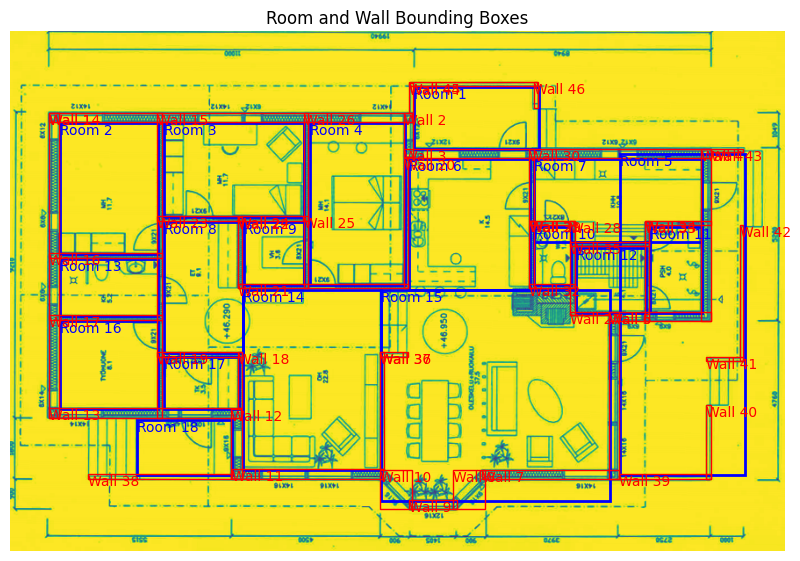

In [24]:
# Example usage with scaling factors
visualize_bboxes(image[0][1], room_bboxes, wall_bboxes)

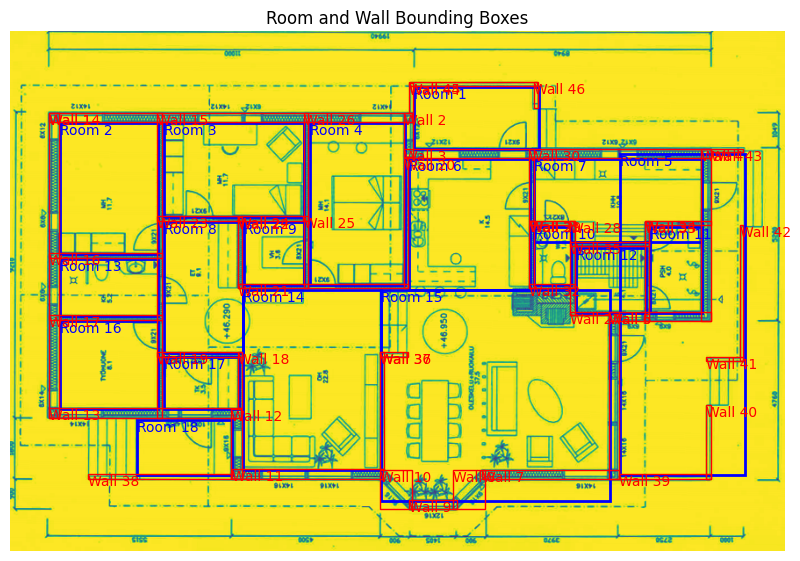

In [25]:
visualize_bboxes(image[0][1], room_bboxes, wall_bboxes)